In [1]:
import numpy as np
import pandas as pd
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

from sklearn.feature_selection.univariate_selection import SelectKBest, chi2, f_classif
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.linear_model import SGDClassifier, SGDRegressor,LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.pipeline import Pipeline

import seaborn as sns

import re
import collections as col

import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline
plt.style.use('ggplot')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
df = pd.read_csv(r'./data/Combined_News_DJIA.csv')
train = df[df['Date'] < '20140101']
test = df[df['Date'] > '20131231']
df.head()
djia = pd.read_csv(r'./data/upload_DJIA_table.csv')

In [3]:
data_merged = djia.merge(df, on='Date')
data_merged['Open_shift'] = data_merged['Open'].shift(1)
data_merged = data_merged.dropna()
data_merged['Label_adj'] = (data_merged['Open_shift'] >= data_merged['Open']).astype('int')
data_merged = data_merged.drop(['Open', 'High', 'Low', 'Close', 'Volume', 'Adj Close', 'Label', 'Open_shift'], axis=1)
train = data_merged[data_merged['Date'] < '20140101']
test = data_merged[data_merged['Date'] > '20131231']

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


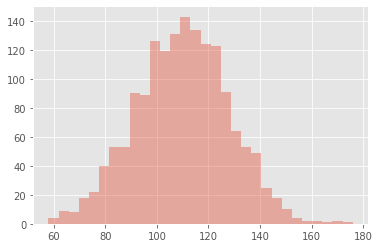

In [4]:
# 新闻描述的平均长度
mean_len = []
for i in range(len(train)):
    mean_len.append(np.mean([len(i) for i in train.loc[:, 'Top1':'Top25'].iloc[i]]))
    
sns.distplot(mean_len, kde=False)

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


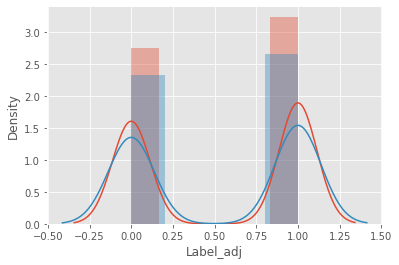

In [5]:
# 标签分布
sns.distplot(train['Label_adj'])
sns.distplot(test['Label_adj'])
plt.show()

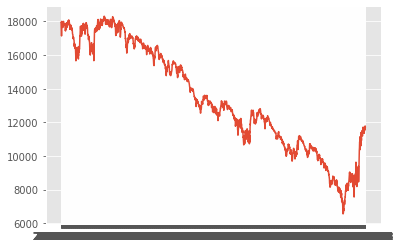

In [6]:
# 道琼斯价格时序图
plt.plot(djia['Date'], djia['Adj Close'])
plt.show()

In [7]:
# 数据处理
# ①将新闻字符串转换为单词数作为输入。
contractions = { 
"ain't": "am not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he's": "he is",
"how'd": "how did",
"how'll": "how will",
"how's": "how is",
"i'd": "i would",
"i'll": "i will",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'll": "it will",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"must've": "must have",
"mustn't": "must not",
"needn't": "need not",
"oughtn't": "ought not",
"shan't": "shall not",
"sha'n't": "shall not",
"she'd": "she would",
"she'll": "she will",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"that'd": "that would",
"that's": "that is",
"there'd": "there had",
"there's": "there is",
"they'd": "they would",
"they'll": "they will",
"they're": "they are",
"they've": "they have",
"wasn't": "was not",
"we'd": "we would",
"we'll": "we will",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"where'd": "where did",
"where's": "where is",
"who'll": "who will",
"who's": "who is",
"won't": "will not",
"wouldn't": "would not",
"you'd": "you would",
"you'll": "you will",
"you're": "you are"
}

In [8]:
def clean_text(text, remove_stopwords = True):
    
    text = text.lower()
    
    # 将简写替换成一般形式 
    if True:
        text = text.split()
        new_text = []
        for word in text:
            if word in contractions:
                new_text.append(contractions[word])
            else:
                new_text.append(word)
        text = " ".join(new_text)
    
    # 格式化单词并删除不需要的字符
    text = re.sub(r'&amp;', '', text) 
    text = re.sub(r'0,0', '00', text) 
    text = re.sub(r'[_"\-;%()|.,+&=*%.,!?:#@\[\]]', ' ', text)
    text = re.sub(r'\'', ' ', text)
    text = re.sub(r'\$', ' $ ', text)
    text = re.sub(r'u s ', ' united states ', text)
    text = re.sub(r'u n ', ' united nations ', text)
    text = re.sub(r'u k ', ' united kingdom ', text)
    text = re.sub(r'j k ', ' jk ', text)
    text = re.sub(r' s ', ' ', text)
    text = re.sub(r' yr ', ' year ', text)
    text = re.sub(r' l g b t ', ' lgbt ', text)
    text = re.sub(r'0km ', '0 km ', text)
    
    # 删除停用词
    if remove_stopwords:
        text = text.split()
        stops = set(stopwords.words("english"))
        text = [w for w in text if not w in stops]
        text = " ".join(text)
    return text

In [9]:
trainheadlines = []
for row in range(0,len(train.index)):
    trainheadlines.append(clean_text(' '.join(str(x) for x in train.iloc[row,1:26])))
    
testheadlines = []
for row in range(0,len(test.index)):
    testheadlines.append(clean_text(' '.join(str(x) for x in test.iloc[row,2:27])))

In [10]:
tokens_all = []
for headlines in trainheadlines:
    tokens = nltk.word_tokenize(headlines)
    tokens_all += tokens
    
counter_train = col.Counter(tokens_all)

tokens_all = []
for headlines in testheadlines:
    tokens = nltk.word_tokenize(headlines)
    tokens_all += tokens
    
counter_test = col.Counter(tokens_all)

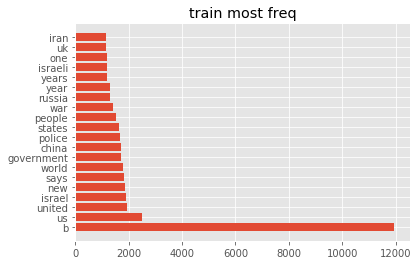

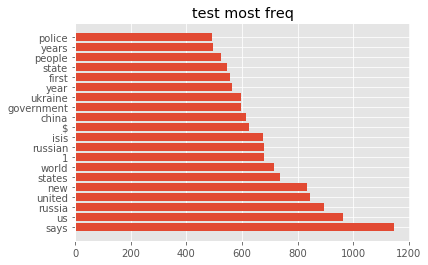

In [11]:
c_train = np.array(counter_train.most_common(20))
c_test = np.array(counter_test.most_common(20))

plt.barh(c_train[:, 0], c_train[:, 1].astype('int'))
plt.title("train most freq")
plt.show()
plt.barh(c_test[:, 0], c_test[:, 1].astype('int'))
plt.title("test most freq")
plt.show()

In [12]:
basicvectorizer = CountVectorizer()
basictrain = basicvectorizer.fit_transform(trainheadlines)
print(basictrain.shape)

(1608, 31585)


In [13]:
train_label = train['Label_adj']
test_label = test['Label_adj']

In [14]:
'''
算法：逻辑回归
输入：有两个连接词的词组数（排除太常见的词，如“a”、“an”、“the”和词太不常见的词数太少）
我们删除频率低于 0.03 或高于 0.97 的短语
'''
advancedvectorizer = TfidfVectorizer( min_df=0.03, max_df=0.97, max_features = 200000, ngram_range = (2, 2))
advancedtrain = advancedvectorizer.fit_transform(trainheadlines)
advancedmodel = LogisticRegression(C=0.25)
advancedmodel = advancedmodel.fit(advancedtrain, train_label)

advancedtest = advancedvectorizer.transform(testheadlines)
preds = advancedmodel.predict(advancedtest)
acc_test=accuracy_score(test_label, preds)
acc_train=accuracy_score(train_label, advancedmodel.predict(advancedtrain))

print('Logic Regression accuracy test: ',acc_test )
print('Logic Regression accuracy train: ',acc_train )

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Logic Regression accuracy test:  0.5580286168521462
Logic Regression accuracy train:  0.6019900497512438


In [15]:
def show_profit(model, t):
    preds_proba = model.predict_proba(advancedtest)

    preds = (preds_proba[:, 1] > t) * 1 + (preds_proba[:, 1] < (1 - t)) * 0 + (preds_proba[:, 1] >= (1-t)) * (preds_proba[:, 1] <= t) * -1

    test_merged = test.merge(djia, on='Date')
    test_merged['preds'] = preds

    test_merged['Open_shift'] = test_merged['Open'].shift(1)
    test_merged = test_merged.dropna()
    test_merged['profit'] = (np.abs((test_merged['Open_shift'] - test_merged['Open'])) * (test_merged['Label_adj'] == test_merged['preds']) - np.abs((test_merged['Open_shift'] - test_merged['Open'])) * (test_merged['Label_adj'] != test_merged['preds'])) * (test_merged['preds'] != -1)
    # test_merged = test_merged.sort_values(by='Date', ascending=True)
    test_merged['cum_profit'] = test_merged['profit'].cumsum()

    plt.plot(test_merged['cum_profit'])
    plt.show()

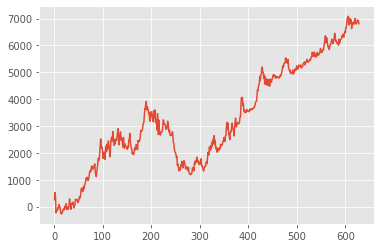

In [16]:
show_profit(advancedmodel, 0.5)

In [17]:
advwords = advancedvectorizer.get_feature_names()
advcoeffs = advancedmodel.coef_.tolist()[0]
advcoeffdf = pd.DataFrame({'Words' : advwords, 
                        'Coefficient' : advcoeffs})
advcoeffdf = advcoeffdf.sort_values(['Coefficient', 'Words'], ascending=[0, 1])
advcoeffdf.head(5)


,Words,Coefficient
28,high court,0.629700
89,white house,0.610499
1,20 years,0.562787
92,world cup,0.531784
21,first time,0.526542


In [18]:
advcoeffdf.tail(5)

,Words,Coefficient
2,30 years,-0.383006
73,south korean,-0.435426
49,nuclear weapons,-0.510371
55,phone hacking,-0.582684
6,around world,-0.671187


In [30]:
from tensorflow.keras.preprocessing import sequence
# from tensorflow.keras.utils import np_utils
from tensorflow.python.keras.utils.np_utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Lambda
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import LSTM, SimpleRNN, GRU
from tensorflow.keras.preprocessing.text import Tokenizer
from collections import defaultdict
from tensorflow.keras import backend as K

In [31]:
max_features = 10000
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.1
maxlen = 500
batch_size = 32
nb_classes = 2

In [32]:
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(trainheadlines)
sequences_train = tokenizer.texts_to_sequences(trainheadlines)
sequences_test = tokenizer.texts_to_sequences(testheadlines)

In [35]:
print('Pad sequences (samples x time)')
X_train = sequence.pad_sequences(sequences_train, maxlen=maxlen)
X_test = sequence.pad_sequences(sequences_test, maxlen=maxlen)

y_train = np.array(train_label)
y_test = np.array(test_label)
Y_train = to_categorical(y_train, nb_classes)
Y_test = to_categorical(y_test, nb_classes)


print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)

Pad sequences (samples x time)
X_train shape: (1608, 500)
X_test shape: (629, 500)


In [36]:
basicmodel = LogisticRegression(C=1.0)
basicmodel = basicmodel.fit(X_train, Y_train[:, 0])

preds1 = basicmodel.predict(X_test)
acc_test=accuracy_score(Y_test[:, 0], preds1)
acc_train=accuracy_score(Y_train[:, 0], basicmodel.predict(X_train))

print('Logic Regression 1 accuracy test: ',acc_test )
print('Logic Regression 1 accuracy train: ',acc_train )

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Logic Regression 1 accuracy test:  0.48012718600953896
Logic Regression 1 accuracy train:  0.7077114427860697


In [37]:
print('Build model...')
model = Sequential()
model.add(Embedding(max_features, 128))
model.add(LSTM(128, dropout=0.5)) 
model.add(Dense(nb_classes))
model.add(Activation('softmax'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print('Train...')
model.fit(X_train, Y_train, batch_size=batch_size, epochs=2) #,
         #validation_data=(X_test, Y_test))
score, acc = model.evaluate(X_test, Y_test,
                            batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)


print("Generating test predictions...")
preds15 = model.predict_classes(X_test, verbose=0)
acc15 = accuracy_score(test_label, preds15)

Build model...
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Train...
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 1608 samples
Epoch 1/2
1608/1608 [==============================] - 50s 31ms/sample - loss: 0.6917 - acc: 0.5398
Epoch 2/2
629/629 [==============================] - 5s 9ms/sample - loss: 0.6072 - acc: 0.6884
Test score: 0.6071835635955459
Test accuracy: 0.68839425
Generating test predictions...


In [38]:
preds15_proba = model.predict_proba(X_test)

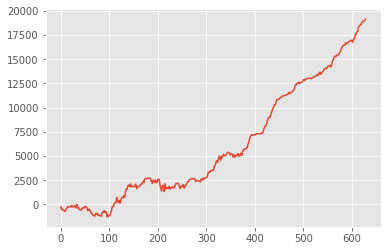

In [39]:
t = 0.55

preds15 = (preds15_proba[:, 1] > t) * 1 + (preds15_proba[:, 1] < (1 - t)) * 0 + (preds15_proba[:, 1] >= (1-t)) * (preds15_proba[:, 1] <= t) * -1

test_merged = test.merge(djia, on='Date')
test_merged['preds'] = preds15

test_merged['Open_shift'] = test_merged['Open'].shift(1)
test_merged = test_merged.dropna()
test_merged['profit'] = (np.abs((test_merged['Open_shift'] - test_merged['Open'])) * (test_merged['Label_adj'] == test_merged['preds']) - np.abs((test_merged['Open_shift'] - test_merged['Open'])) * (test_merged['Label_adj'] != test_merged['preds'])) * (test_merged['preds'] != -1)
# test_merged = test_merged.sort_values(by='Date', ascending=True)
test_merged['cum_profit'] = test_merged['profit'].cumsum()

plt.plot(test_merged['cum_profit'])
plt.show()
